In [1]:
import json
import os
from pycococreatortools import pycococreatortools
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from json import JSONDecodeError
image_witdh = None
image_height = None
filename_prefix="captures_"
glock_id=2
perception_version = '0.3.0'
root_path='/home/m/weapons/30k'
files_ = os.listdir(root_path)
files_path=''
for f in files_:
    if f.startswith("Dataset"):
        files_path = os.path.join(root_path,f)
#files_path=os.path.join(root_path, 'Dataset2fd2fa2d-c266-4a43-8183-7168949b9979')
files_all = os.listdir(files_path)
files_captures = []
for filename in files_all:
    if filename.startswith(filename_prefix):
        files_captures.append(os.path.join(files_path,filename))

In [2]:
def get_image_width_height(filename, image_height, image_width):
    if image_width is None or image_height is None:
        path = os.path.join(root_path, filename)
        img = cv2.imread(path)
        image_height,image_width, _ = img.shape
        print("shape", image_height, image_width)
    return image_height ,image_width 

In [3]:
def get_color_info():
    label_id = {}
    label_color = {}
    out_color = {}
    rgb_vals = {}
    with open(os.path.join(files_path, 'annotation_definitions.json'),'r') as f:
        json_dict = json.load(f)
        for ann_def in json_dict['annotation_definitions']:
            for sp in ann_def["spec"]:
                if 'label_id' in sp and 'label_name' in sp:
                    label_id[sp['label_id']] = sp['label_name']
                if 'label_name' in sp and "pixel_value" in sp:
                    label_color[sp['label_name']] = sp['pixel_value']
        for key in label_id:
            out_color[key] = label_color[label_id[key]]
        #out color is in format {1: {'r': 0.0, 'g': 1.0, 'b': 0.0, 'a': 1.0}
        for key in out_color:
            rgb_vals[key] = np.array([int(out_color[key]['r']*255), int(out_color[key]['g']*255), int(out_color[key]['b']*255)]) 
    return rgb_vals

In [4]:
print(get_color_info())

{1: array([  0, 255,   0]), 2: array([255, 255, 255]), 3: array([127, 127, 127]), 4: array([103, 255,  81]), 5: array([255, 237,  52]), 6: array([255, 166,  16]), 7: array([255, 144,  10]), 8: array([ 16, 255,  70]), 9: array([ 47, 255,  74]), 10: array([  0,   0, 255])}


In [5]:
def annotation_from_mask(semantic_filename,x,y,width,height,image_id,annotation_id, label_id):
    x,y,width,height = [int(val) for val in [x,y,width,height]]
    annotation_filename=os.path.join(root_path, semantic_filename)
    image=cv2.imread(annotation_filename)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotations = []
    color_info = get_color_info()
    
    full_mask = cv2.inRange(image, color_info[label_id]-2, color_info[label_id]+2)
    crop_mask = np.zeros_like(full_mask)
    crop_mask[y:y+height, x:x+width] = full_mask[y:y+height, x:x+width]
    annotation_info = pycococreatortools.create_annotation_info(
        annotation_id=annotation_id, image_id=image_id, category_info={'is_crowd':0, "id":label_id}, binary_mask=crop_mask,
        image_size=(image_witdh,image_height), tolerance=2)

    return annotation_info

In [6]:
end_json = {}
end_json['type'] = "instances"
end_json['categories'] = [{"supercategory": "weapon","id": 1,"name": "AK-74m_synth"},
                            {"supercategory": "weapon","id": 2,"name": "colt_synth"},
                            {"supercategory": "weapon","id": 3,"name": "danwesson_synth"},
                            {"supercategory": "weapon","id": 4,"name": "enfield_synth"},
                            {"supercategory": "weapon","id": 5,"name": "glock_synth"},
                            {"supercategory": "weapon","id": 6,"name": "m4_synth"},
                            {"supercategory": "weapon","id": 7,"name": "mp5_synth"},
                            {"supercategory": "weapon","id": 8,"name": "scar_synth"},
                            {"supercategory": "weapon","id": 9,"name": "thompson_synth"},
                            {"supercategory": "weapon","id": 10,"name": "ab10_synth"}]
end_json['images'], end_json["annotations"] = [],[]

In [7]:
image_id =0
annotation_id =0
for filename in tqdm(files_captures):
    f = open(filename, "r")
    try:
        json_dict = json.load(f)
    except JSONDecodeError as e:
        print(e)
        continue
    for capture in json_dict['captures']:
        image_height, image_witdh = get_image_width_height(capture['filename'], image_height,image_witdh)
        image_id+=1
        image_annotation = {}
        image_annotation['file_name'] = capture['filename']
        image_annotation['id'] = image_id
        image_annotation['width'] = image_witdh
        image_annotation['height'] = image_height
        image_annotation['license'] = 0
        end_json['images'].append(image_annotation)
        semantic_filename = '' 
        for annotation in capture['annotations']:
            if 'filename' in annotation.keys():
                semantic_filename = annotation['filename']
                
        for annotation in capture['annotations']:
            if 'values' in annotation.keys():
                for some_val in annotation['values']:
                    annotation_id+=1
                    x,y,width, height=some_val['x'], some_val['y'],some_val['width'],some_val['height']   
                    new_annotation = annotation_from_mask(semantic_filename, x,y,width, height,image_id, annotation_id, some_val['label_id'])
                    if new_annotation:
                        end_json["annotations"].append(new_annotation)
        

  0%|          | 0/207 [00:00<?, ?it/s]

shape 628 839


  5%|▌         | 11/207 [01:54<33:31, 10.26s/it]

Expecting value: line 1 column 1 (char 0)


 15%|█▍        | 31/207 [05:22<32:41, 11.15s/it]

Expecting value: line 1 column 1 (char 0)


 19%|█▉        | 39/207 [06:40<29:24, 10.50s/it]

Expecting value: line 1 column 1 (char 0)


 26%|██▌       | 54/207 [09:13<28:04, 11.01s/it]

Expecting value: line 1 column 1 (char 0)


 30%|██▉       | 62/207 [10:29<25:14, 10.44s/it]

Expecting value: line 1 column 1 (char 0)


 37%|███▋      | 76/207 [12:53<23:47, 10.90s/it]

Expecting value: line 1 column 1 (char 0)


 43%|████▎     | 88/207 [14:55<21:26, 10.81s/it]

Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)


 45%|████▌     | 94/207 [15:39<17:03,  9.06s/it]

Expecting value: line 1 column 1 (char 0)


 53%|█████▎    | 110/207 [18:23<18:00, 11.14s/it]

Expecting value: line 1 column 1 (char 0)


 58%|█████▊    | 121/207 [20:11<15:14, 10.63s/it]

Expecting value: line 1 column 1 (char 0)


 64%|██████▍   | 132/207 [21:56<12:33, 10.04s/it]

Expecting value: line 1 column 1 (char 0)


 71%|███████   | 147/207 [24:25<10:09, 10.16s/it]

Expecting value: line 1 column 1 (char 0)


 83%|████████▎ | 172/207 [28:37<06:05, 10.46s/it]

Expecting value: line 1 column 1 (char 0)


 88%|████████▊ | 183/207 [30:20<04:06, 10.25s/it]

Expecting value: line 1 column 1 (char 0)


 98%|█████████▊| 203/207 [33:26<00:39,  9.76s/it]

Expecting value: line 1 column 1 (char 0)


100%|██████████| 207/207 [33:56<00:00,  9.84s/it]


In [8]:
annotation_file=os.path.join(root_path,'trainval.json')
with open(annotation_file, 'w') as f:
    json.dump(end_json, f)

In [9]:
from pycocotools.coco import COCO
import pylab
import skimage.io as io
coco = COCO(annotation_file)

/home/m/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


loading annotations into memory...
Done (t=3.35s)
creating index...
index created!


In [10]:
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))



Custom COCO categories: 
AK-74m_synth colt_synth danwesson_synth enfield_synth glock_synth m4_synth mp5_synth scar_synth thompson_synth ab10_synth

Custom COCO supercategories: 
weapon


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

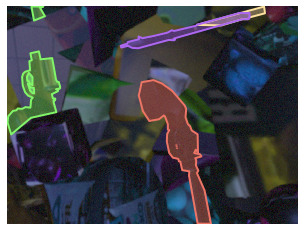

In [11]:
category_ids = coco.getCatIds()
print(category_ids)
image_ids = coco.getImgIds()
print(image_ids)
image_data = coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
image = io.imread(os.path.join(root_path,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = coco.loadAnns(annotation_ids)
coco.showAnns(annotations)